In [1]:
! pip install pickle 
! pip install joblib 

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns   
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Abas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Abas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('laptop_Price.csv', encoding='latin1')

In [3]:
df.head()

,,,,,,,,,,,The contents of the file /laptop-price-predictor/laptop-price-predictor/data/laptop_Price.csv are as follows:
laptop_id,company,product,typename,screenresolution,cpu,ram,memory,gpu,opsys,weight,price_euros
1,Dell,XPS 13,Ultrabook,1920x1080,Intel i7 10th Gen,16GB,512GB SSD,NVIDIA GTX 1650,Windows 10,1.2,1200
2,Apple,MacBook Air,Ultrabook,2560x1600,Apple M1,8GB,256GB SSD,Apple Integrated,macOS,1.29,999
3,HP,Spectre x360,Convertible,1920x1080,Intel i5 11th Gen,8GB,512GB SSD,Intel Iris Xe,Windows 10,1.3,1100
4,Lenovo,ThinkPad X1,Ultrabook,2560x1440,Intel i7 8th Gen,16GB,1TB SSD,NVIDIA MX250,Windows 10,1.5,1500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12 entries, ('laptop_id', 'company', 'product', 'typename', 'screenresolution', 'cpu', 'ram', 'memory', 'gpu', 'opsys', 'weight') to ('(Note: The above data is a sample representation. You can modify or expand it based on your actual dataset.)', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)
Data columns (total 1 columns):
 #   Column                                                                                                         Non-Null Count  Dtype 
---  ------                                                                                                         --------------  ----- 
 0   The contents of the file /laptop-price-predictor/laptop-price-predictor/data/laptop_Price.csv are as follows:  11 non-null     object
dtypes: object(1)
memory usage: 3.5+ KB


In [5]:
df.describe()

,The contents of the file /laptop-price-predictor/laptop-price-predictor/data/laptop_Price.csv are as follows:
count,11
unique,10
top,999
freq,2


In [6]:
df.isnull().sum()

The contents of the file /laptop-price-predictor/laptop-price-predictor/data/laptop_Price.csv are as follows:    1
dtype: int64

In [7]:
#Converted all columns names to lower case for easy cleaning and future processing
df.columns = df.columns.str.lower()
df.columns


Index(['the contents of the file /laptop-price-predictor/laptop-price-predictor/data/laptop_price.csv are as follows:'], dtype='object')

In [8]:
# Remove 'GB' from RAM and convert to integer
df['ram'] = df['ram'].str.replace("GB","").astype(int)

# Remove 'kg' from Weight and convert to float
df['weight'] = df['weight'].str.replace("kg","").astype(float)

# Clean up 'Memory' column (split HDD/SSD/etc.)
df['memory'] = df['memory'].str.replace("GB","").str.replace("TB","000")
df['memory'] = df['memory'].str.replace(r'\D', '', regex=True).replace('', '0').astype(int)

# Convert Inches to float
df['inches'] = df['inches'].astype(float)

KeyError: 'ram'

In [ ]:
# Identify categorical columns with missing values
categorical_cols = df.select_dtypes(include=['object']).columns
missing_categorical = df[categorical_cols].isnull().sum()
missing_categorical = missing_categorical[missing_categorical > 0]

print("Categorical columns with missing values:")
print(missing_categorical)

# Handle each categorical column based on number of unique values
for col in missing_categorical.index:
    unique_count = df[col].nunique()
    
    if unique_count <= 15: 
        mode_value = df[col].mode()[0]
        print(f"Filling {missing_categorical[col]} missing values in '{col}' with mode: '{mode_value}'")
        df[col].fillna(mode_value, inplace=True)
    else:
        print(f"Filling {missing_categorical[col]} missing values in '{col}' with 'Unknown'")
        df[col].fillna('Unknown', inplace=True)

print("\nMissing values after handling categorical columns:")
print(df[missing_categorical.index].isnull().sum())

Categorical columns with missing values:
Series([], dtype: int64)

Missing values after handling categorical columns:
Series([], dtype: float64)


In [ ]:
# Identify missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Handle missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col == 'Price_euros':
            df.dropna(subset=[col], inplace=True)
        elif df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            if df[col].nunique() < 20:
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)

print("\nMissing values after handling:\n", df.isnull().sum().sum())


Missing values per column:
 Series([], dtype: int64)

Missing values after handling:
 0


In [ ]:
# Address outliers in numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound)

In [ ]:
# # Convert categorical features to numerical representations

# # 1. Label Encoding for ordinal categorical features
label_encoder = LabelEncoder()
ordinal_features = ['Ram']  # Add other ordinal features if any

for feature in ordinal_features:
     if feature in df.columns:
         df[feature] = label_encoder.fit_transform(df[feature])
         print(f"Label encoded {feature}: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,macOS,1.83,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


In [ ]:
# 2. Correlation coefficients with Price_euros
correlation_with_price = df.select_dtypes(include=[np.number]).corr()['price_euros'].sort_values(ascending=False)
correlation_with_price = correlation_with_price[correlation_with_price.index != 'price_euros']
print("Correlation with price_euros:")
print(correlation_with_price)

Correlation with price_euros:
ram          0.741961
memory       0.230211
weight       0.115558
laptop_id    0.071860
inches       0.042062
Name: price_euros, dtype: float64


In [ ]:
# 10. Divide data into price tiers (low, medium, high)
if 'price_euros' in df.columns:
    df['Price_Tier'] = pd.qcut(df['price_euros'], 3, labels=['Low', 'Medium', 'High'])
    print("Price Tier Distribution:")
    print(df['Price_Tier'].value_counts())

Price Tier Distribution:
Price_Tier
High      435
Low       434
Medium    434
Name: count, dtype: int64


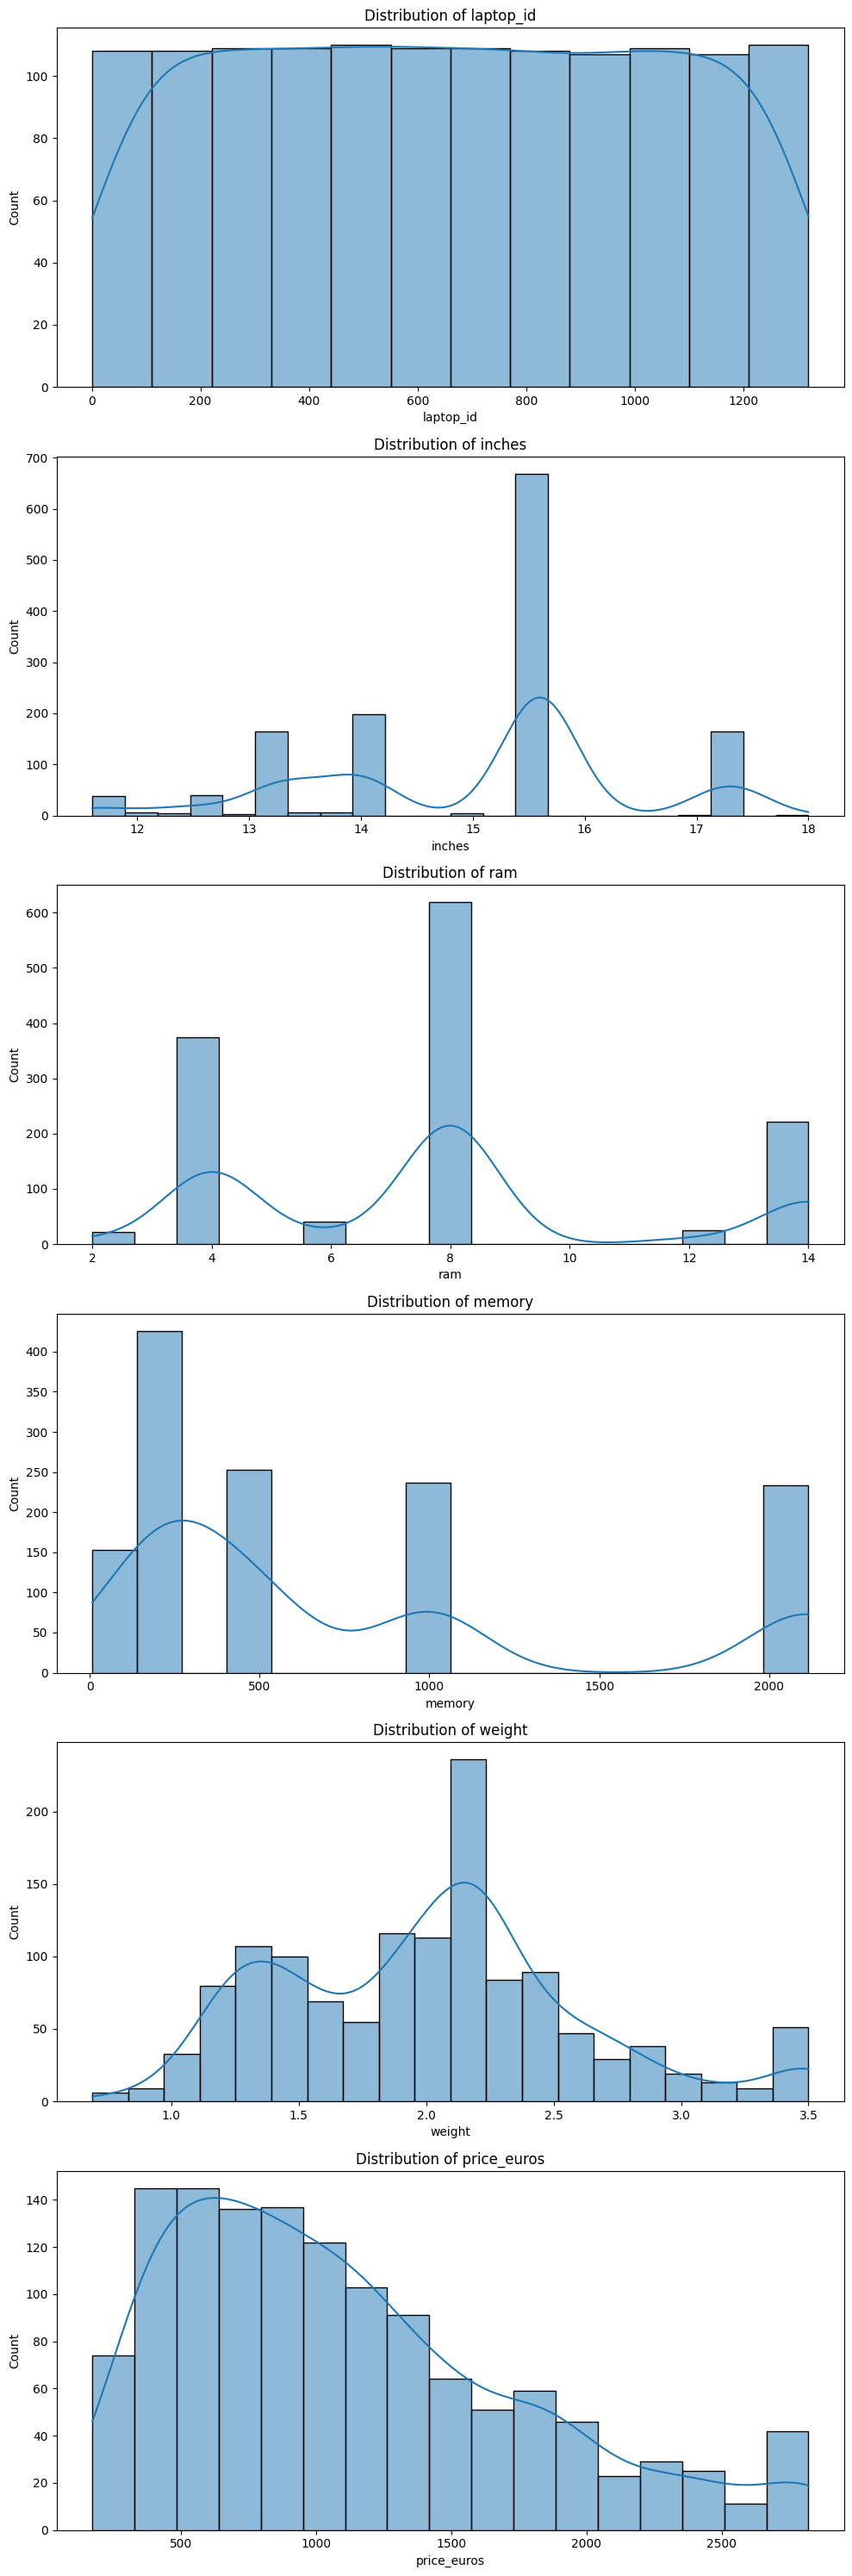

In [ ]:
# 1. Distribution: Histogram for all numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('Price_euros') if 'Price_euros' in numerical_features else None

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 5*len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

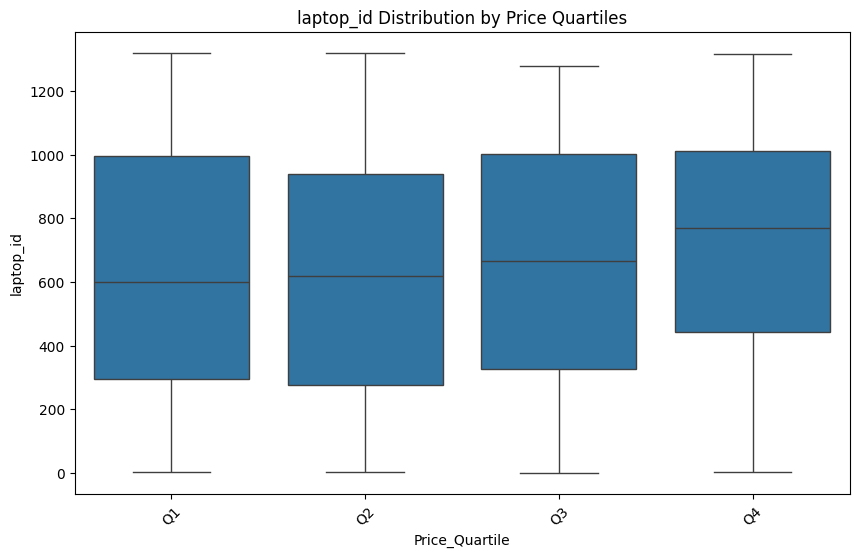

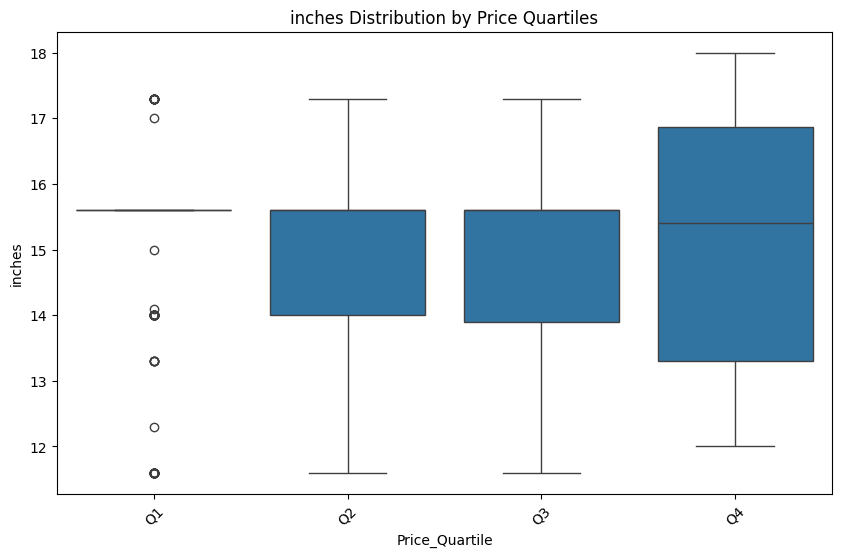

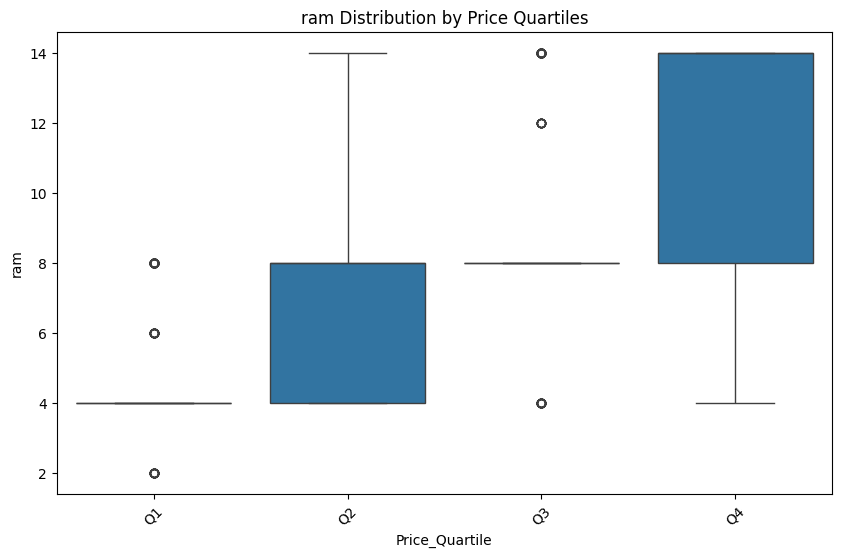

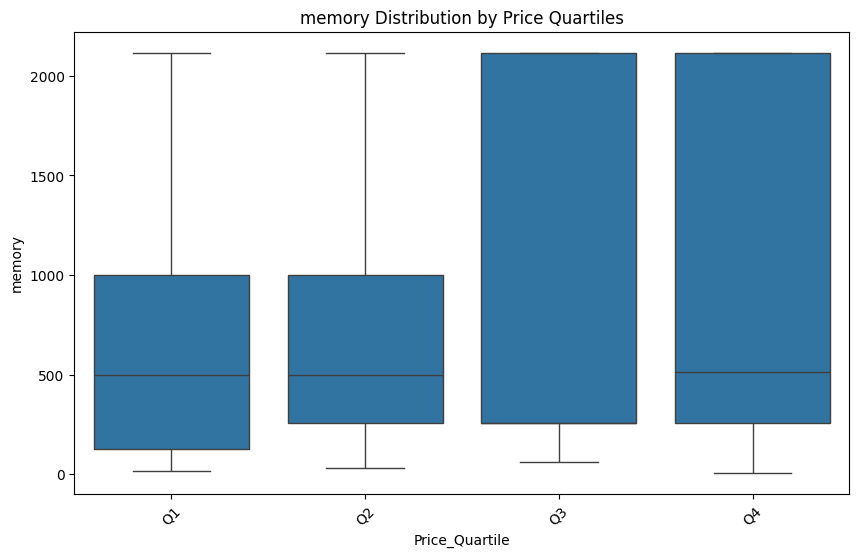

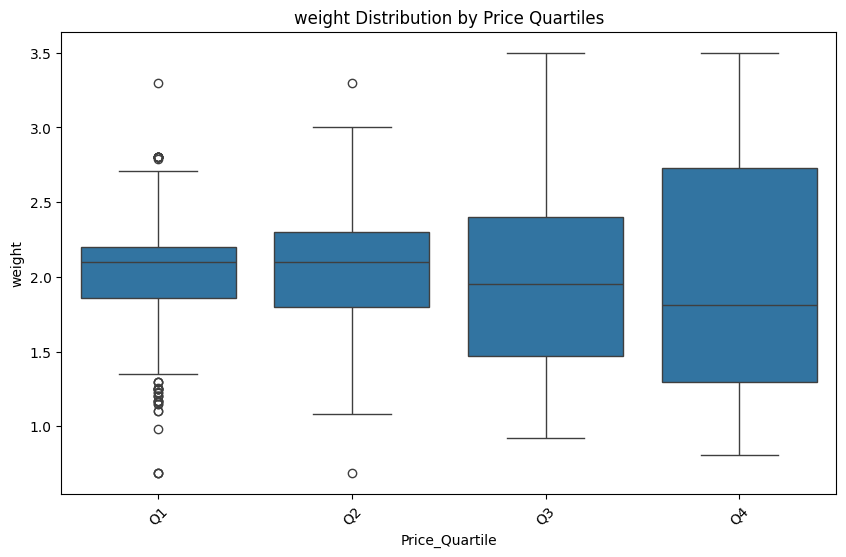

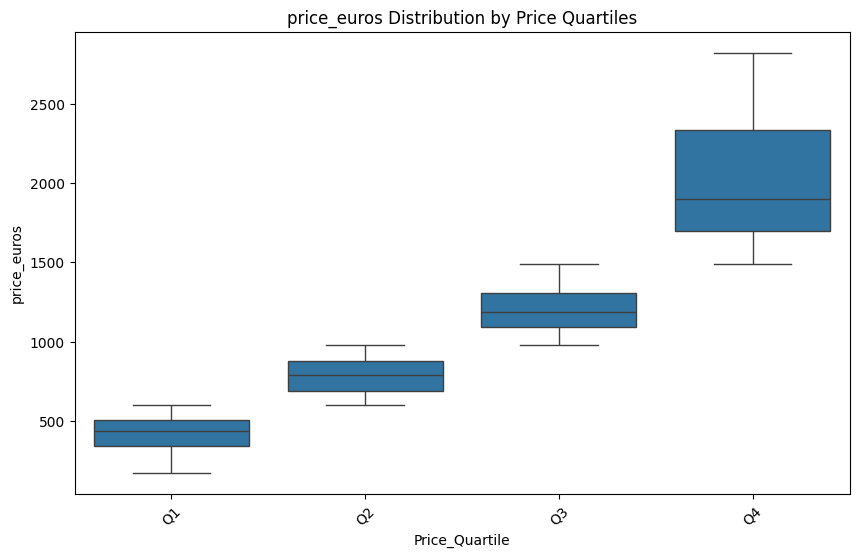

In [ ]:
# 3. Boxplots by price quartiles
if 'price_euros' in df.columns:
    df['Price_Quartile'] = pd.qcut(df['price_euros'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Price_Quartile', y=feature, data=df)
        plt.title(f'{feature} Distribution by Price Quartiles')
        plt.xticks(rotation=45)
        plt.show()

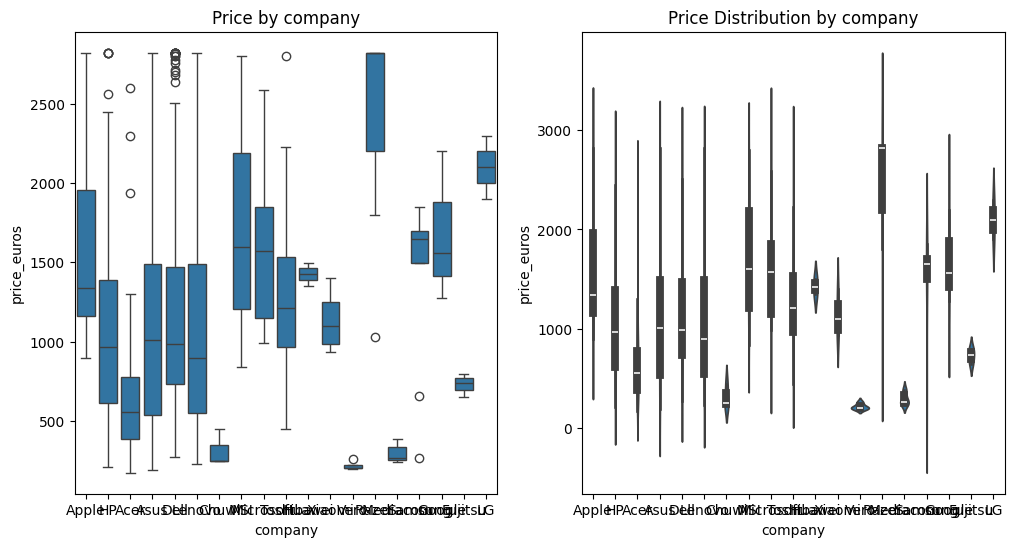

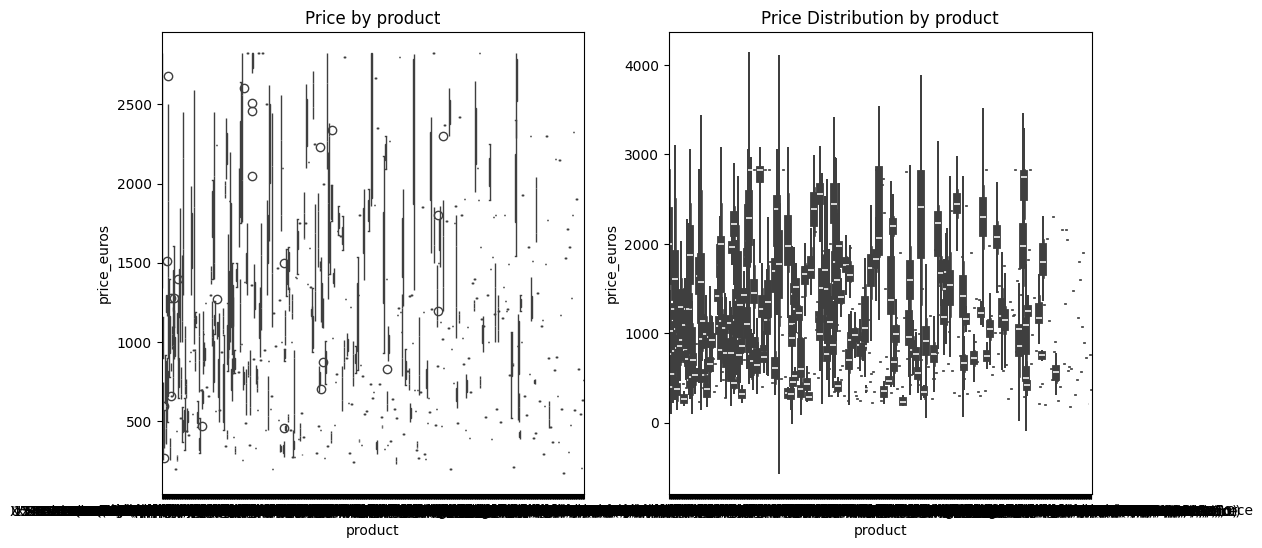

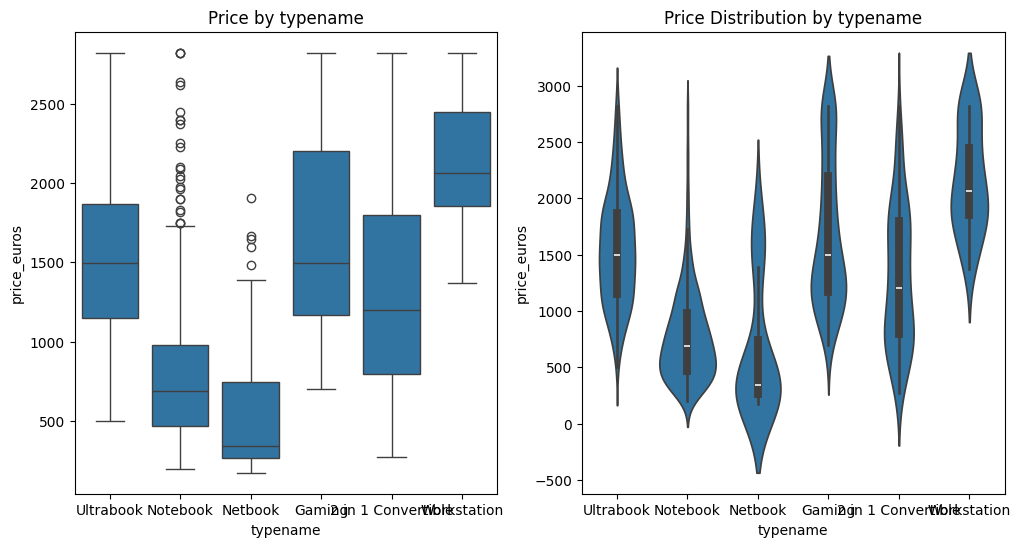

In [ ]:
# 4. Boxplots/Violin plots of price distribution per category
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

for feature in categorical_features[:3]:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x=feature, y='price_euros', data=df)
    plt.title(f'Price by {feature}')

    
    plt.subplot(1, 2, 2)
    sns.violinplot(x=feature, y='price_euros', data=df)
    plt.title(f'Price Distribution by {feature}')
 
    
 

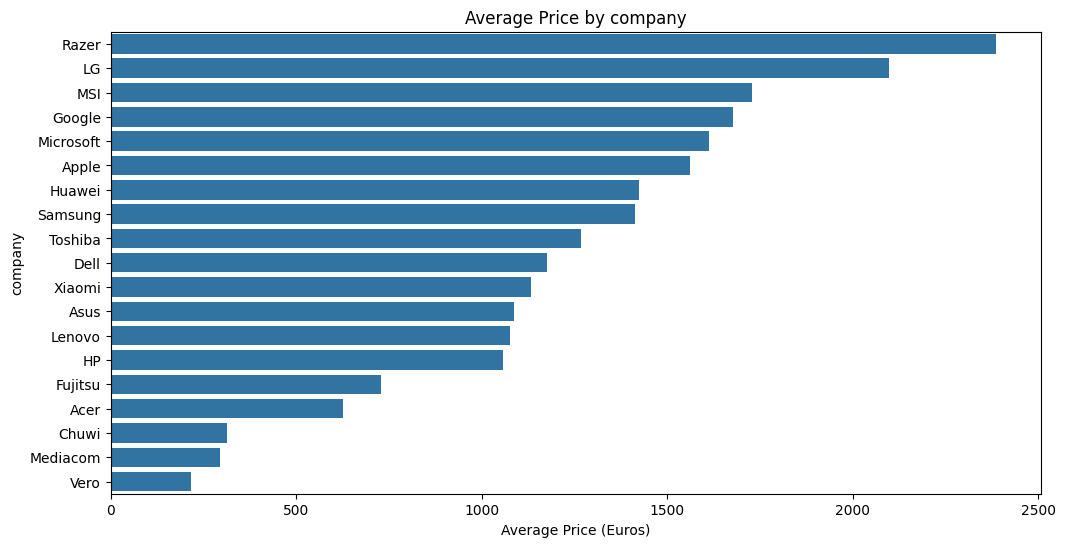

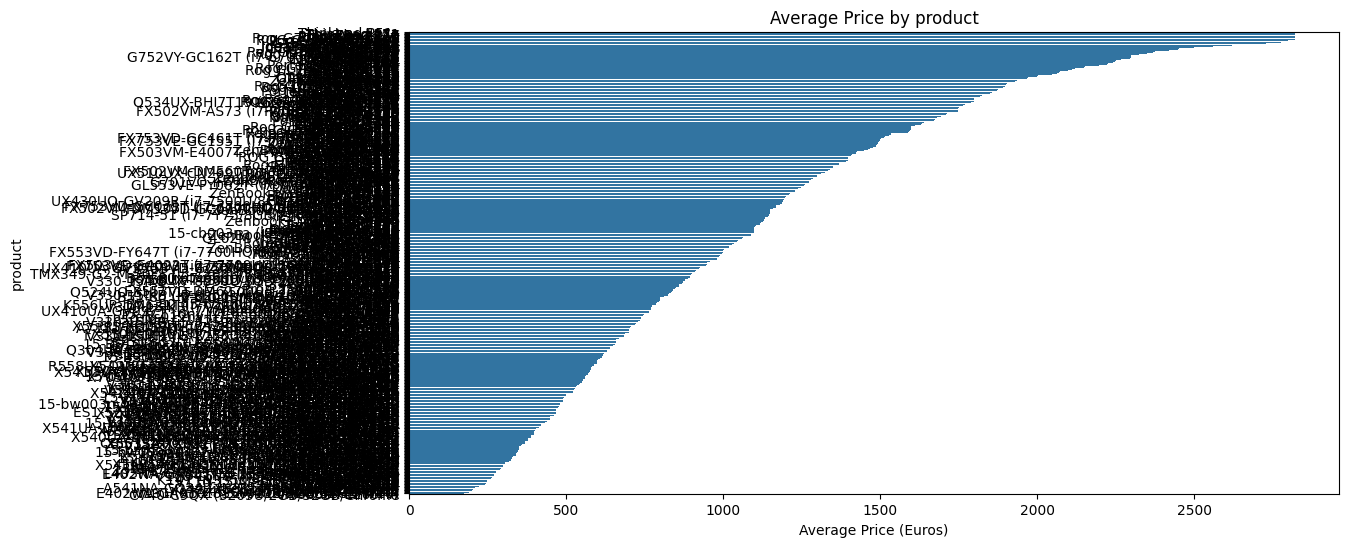

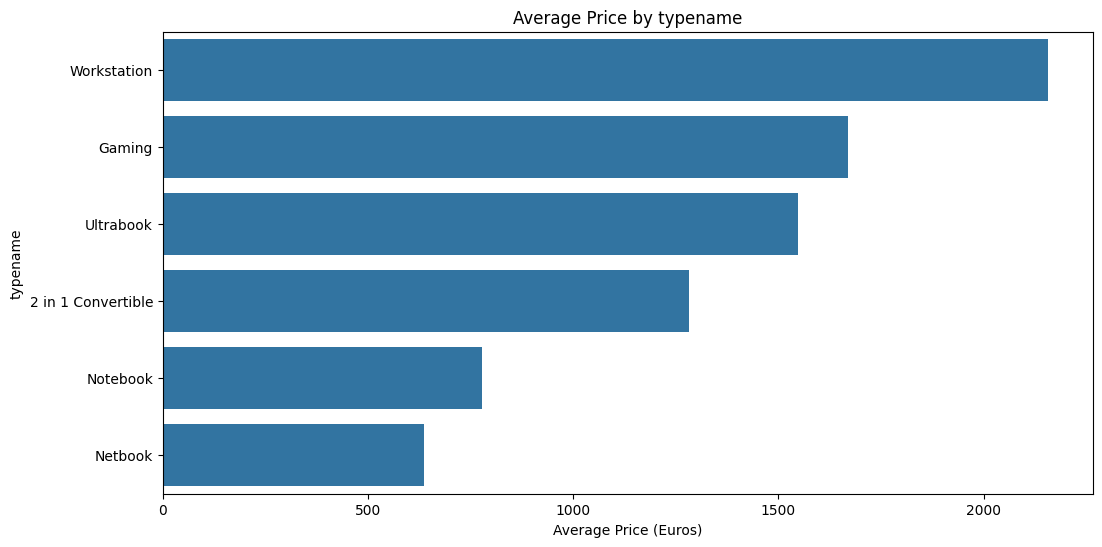

In [ ]:
# 5. Bar charts of average price per category
for feature in categorical_features[:3]:
    avg_prices = df.groupby(feature)['price_euros'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_prices.values, y=avg_prices.index)
    plt.title(f'Average Price by {feature}')
    plt.xlabel('Average Price (Euros)')
    plt.show()

Top 5 Positive Correlations with Price:
ram          0.741961
memory       0.230211
weight       0.115558
laptop_id    0.071860
inches       0.042062
Name: price_euros, dtype: float64

Top 5 Negative Correlations with Price:
ram          0.741961
memory       0.230211
weight       0.115558
laptop_id    0.071860
inches       0.042062
Name: price_euros, dtype: float64


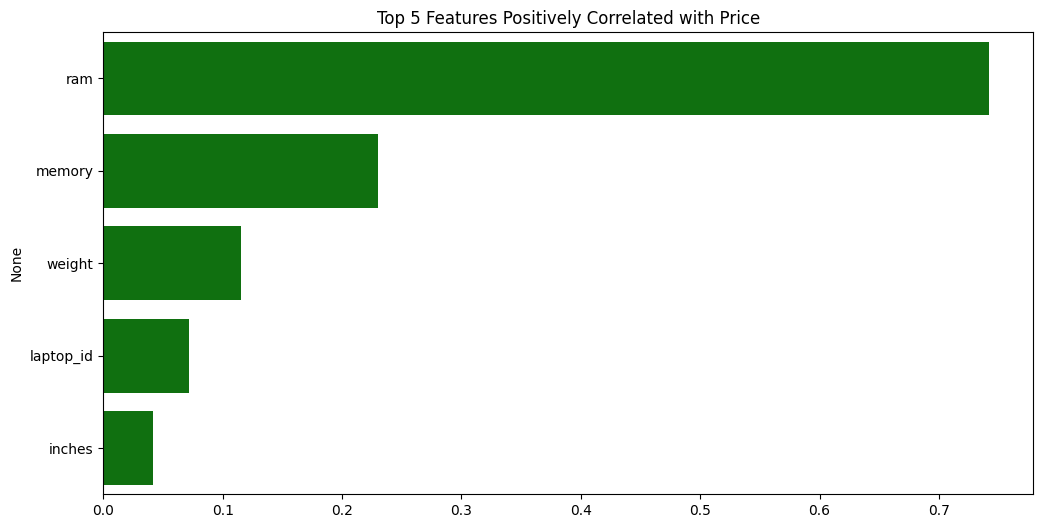

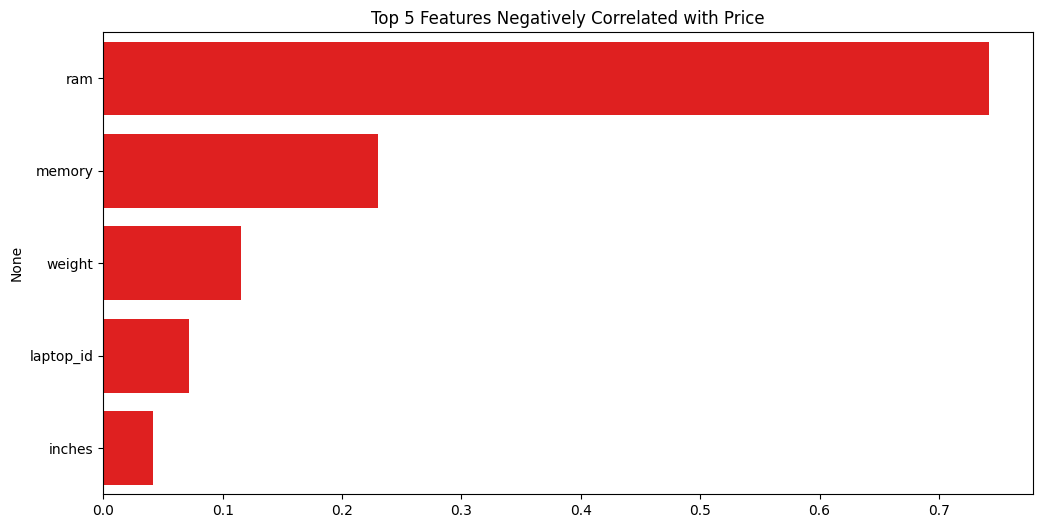

In [ ]:
# 7. Price correlation ranking (top positive/negative)
if 'price_euros' in df.columns:
    top_positive = correlation_with_price.head(5)
    top_negative = correlation_with_price.tail(5)

    print("Top 5 Positive Correlations with Price:")
    print(top_positive)
    print("\nTop 5 Negative Correlations with Price:")
    print(top_negative)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_positive.values, y=top_positive.index, color='green')
    plt.title('Top 5 Features Positively Correlated with Price')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_negative.values, y=top_negative.index, color='red')
    plt.title('Top 5 Features Negatively Correlated with Price')
    plt.show()

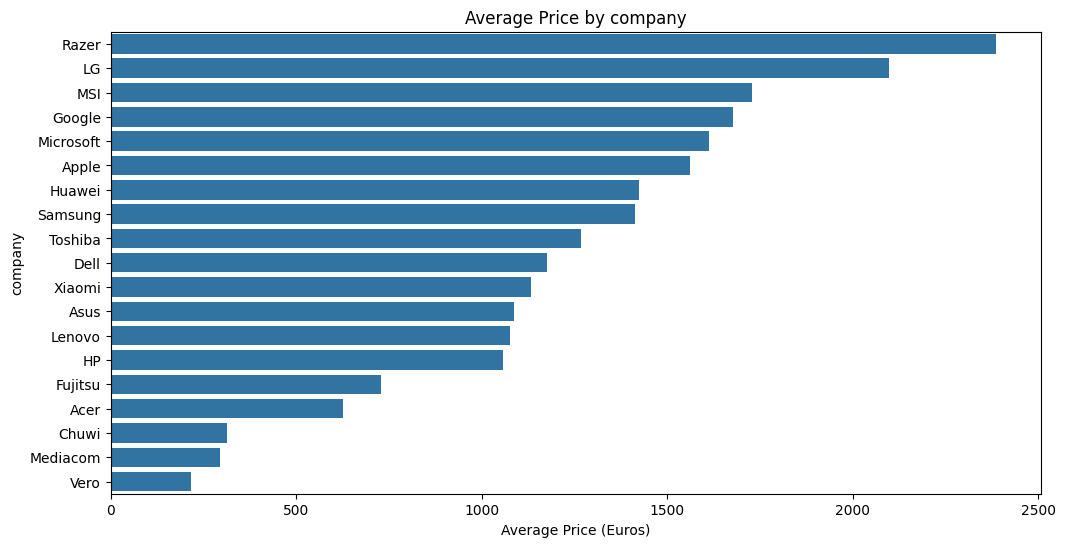

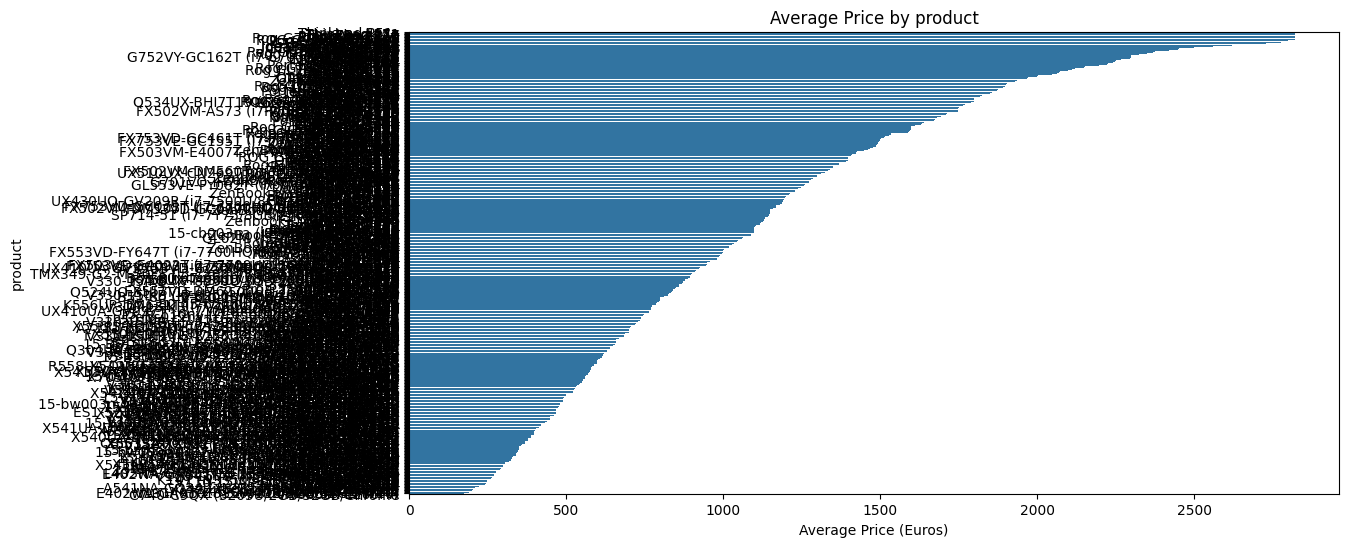

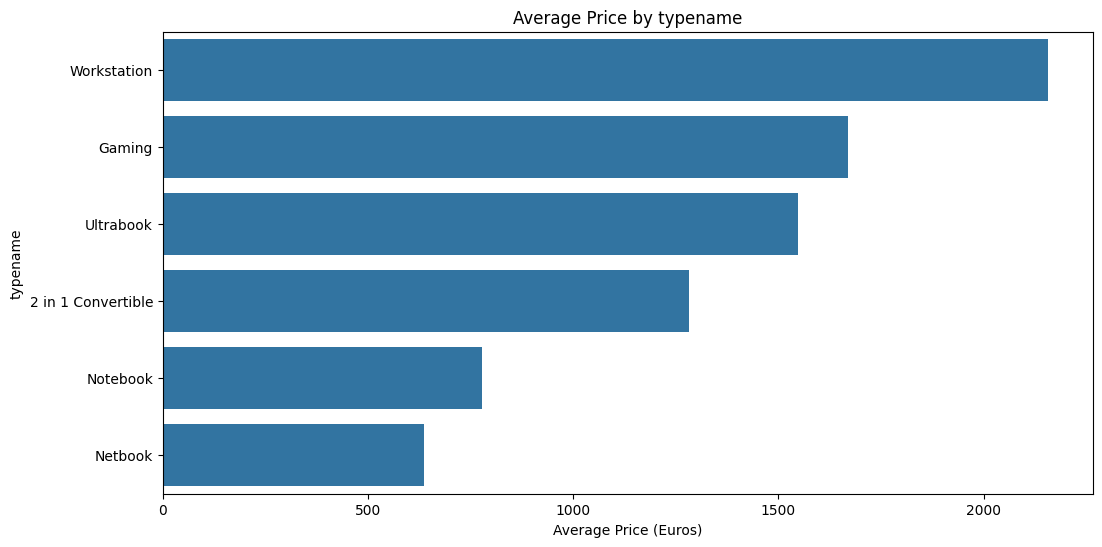

In [ ]:
# 5. Bar charts of average price per category
for feature in categorical_features[:3]:
    avg_prices = df.groupby(feature)['price_euros'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_prices.values, y=avg_prices.index)
    plt.title(f'Average Price by {feature}')
    plt.xlabel('Average Price (Euros)')
    plt.show()

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


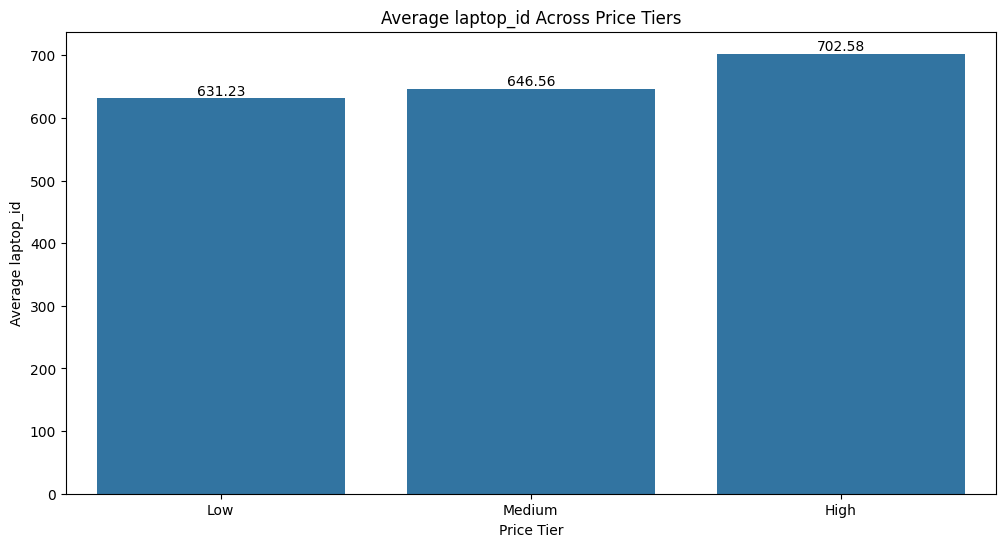

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


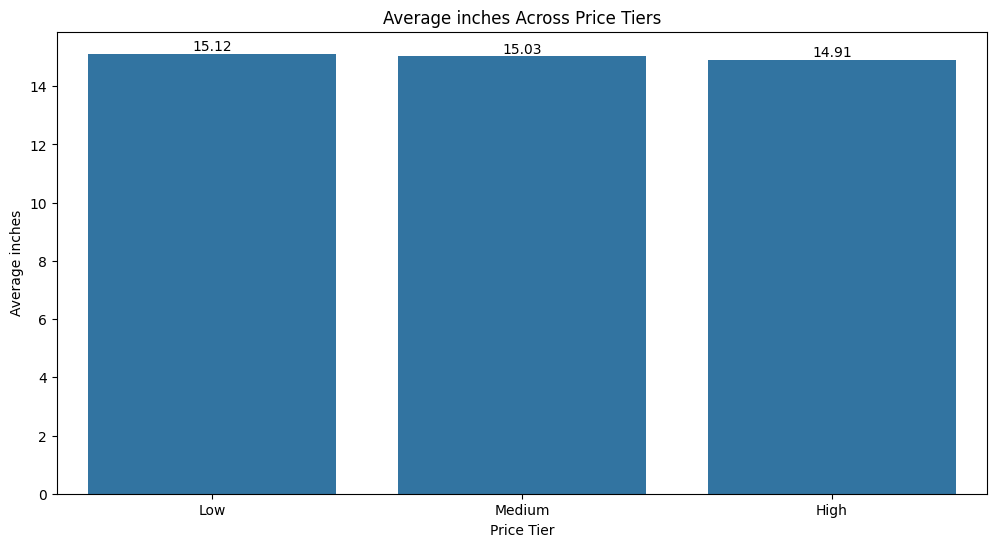

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


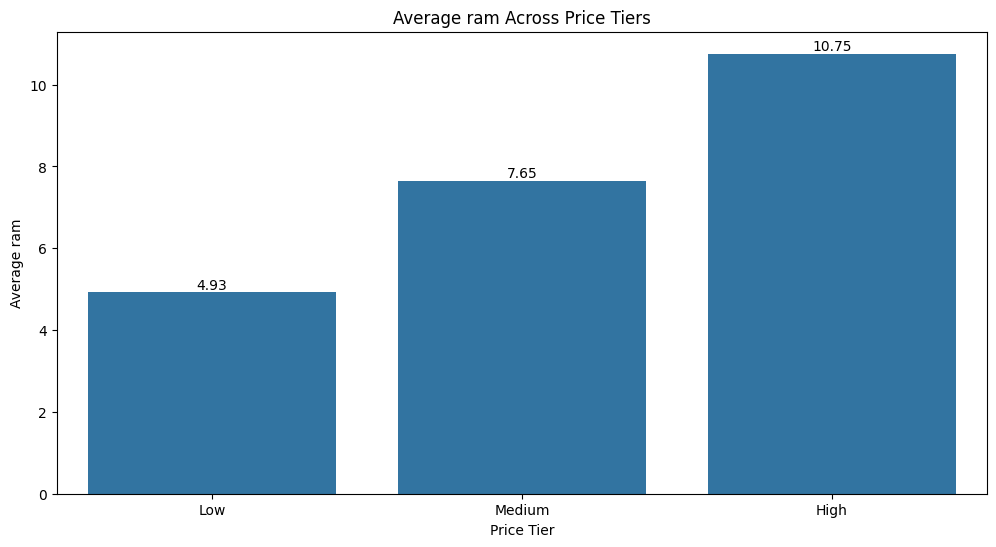

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


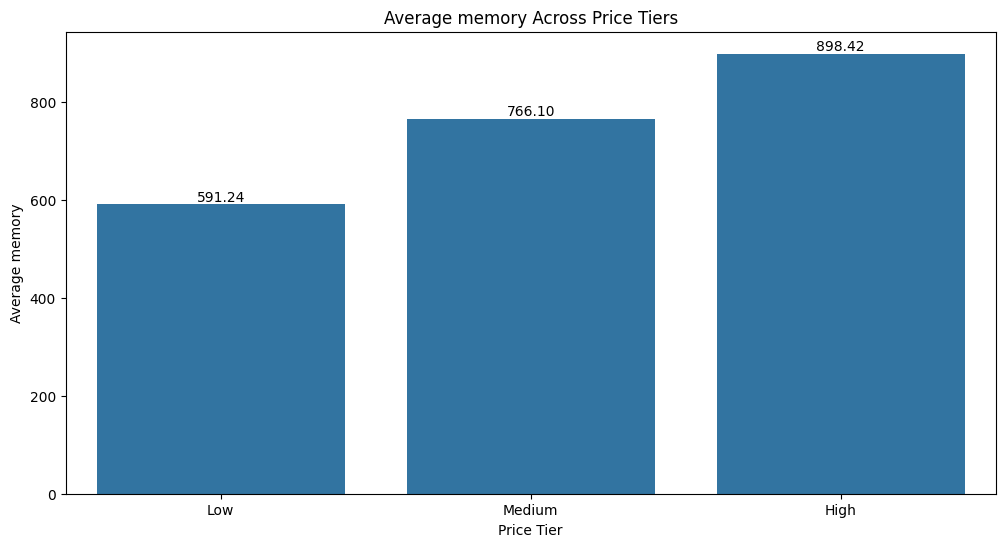

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


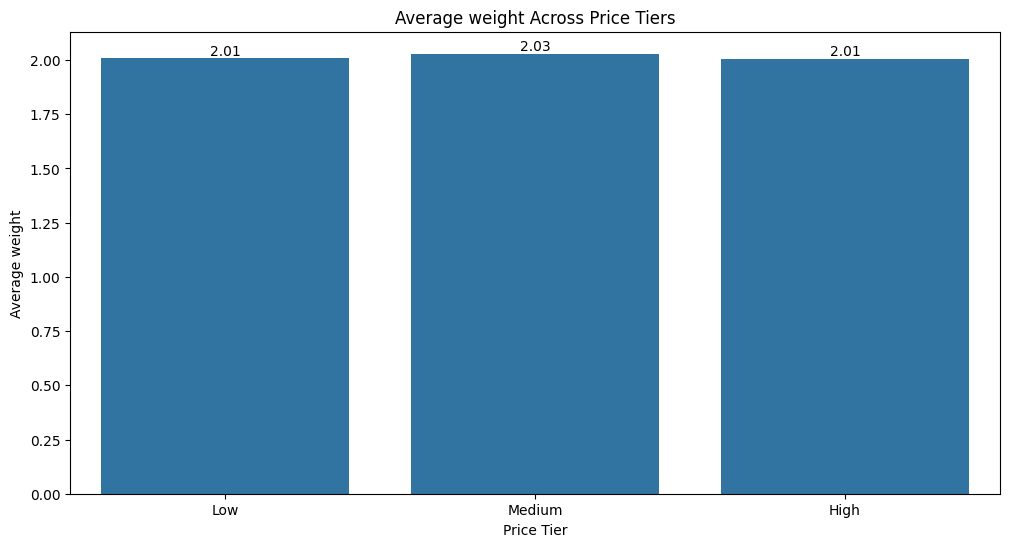

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\2234193123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_means = df.groupby('Price_Tier')[feature].mean()


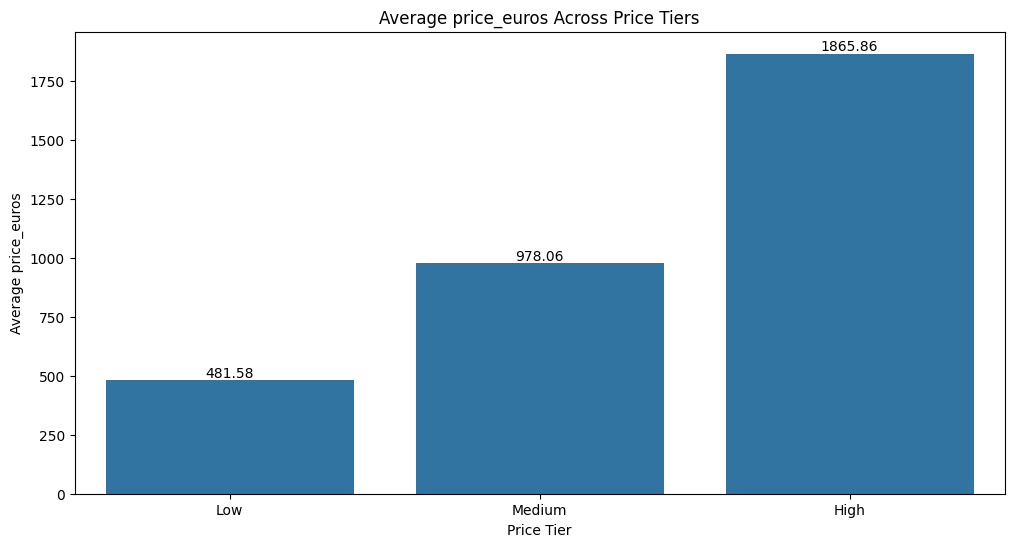

In [ ]:
# 11. Compare feature distributions across price segments
for feature in numerical_features:
        plt.figure(figsize=(12, 6))

        tier_means = df.groupby('Price_Tier')[feature].mean()
        sns.barplot(x=tier_means.index, y=tier_means.values)
        plt.title(f'Average {feature} Across Price Tiers')
        plt.ylabel(f'Average {feature}')
        plt.xlabel('Price Tier')

        for i, value in enumerate(tier_means.values):
            plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
        
        plt.show()

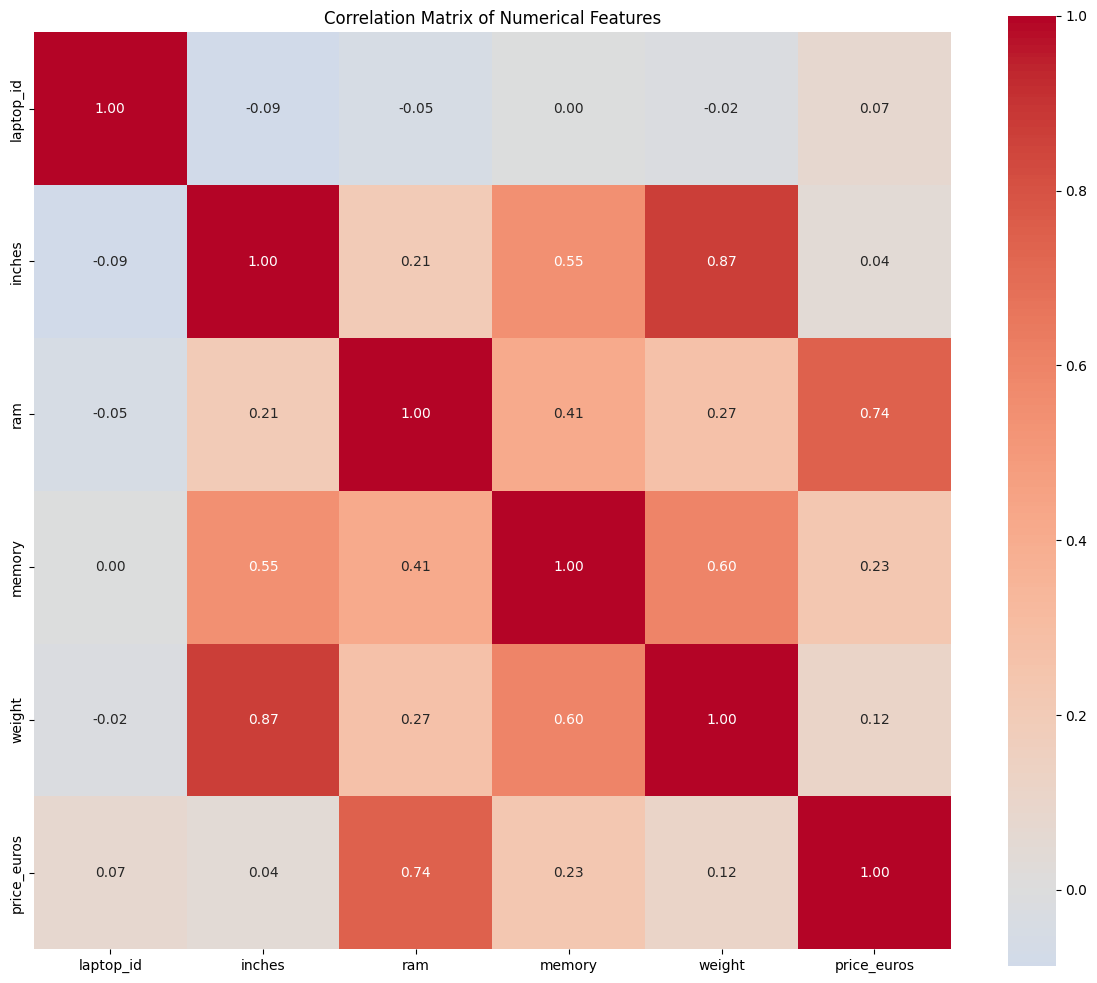

In [ ]:
# 1. Correlation matrix of all numerical features
numerical_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [ ]:
# 12. Identify premium features in high-price laptops
if 'Price_Tier' in df.columns:
    premium_features = {}
    for feature in categorical_features:
        high_tier_mode = df[df['Price_Tier'] == 'High'][feature].mode()[0]
        premium_features[feature] = high_tier_mode

    print("Most Common Features in High-Price Tier:")
    for feature, value in premium_features.items():
        print(f"{feature}: {value}")

Most Common Features in High-Price Tier:
company: Dell
product: XPS 13
typename: Ultrabook
screenresolution: Full HD 1920x1080
cpu: Intel Core i7 7700HQ 2.8GHz
gpu: Intel HD Graphics 620
opsys: Windows 10
Price_Tier: High
Price_Quartile: Q4


In [ ]:
# 13. Budget vs Premium characteristic differences
if 'Price_Tier' in df.columns:
    print("Budget vs Premium Comparison:")
    for feature in numerical_features:
        budget_mean = df[df['Price_Tier'] == 'Low'][feature].mean()
        premium_mean = df[df['Price_Tier'] == 'High'][feature].mean()
        difference = premium_mean - budget_mean
        print(f"{feature}: Budget={budget_mean:.2f}, Premium={premium_mean:.2f}, Diff={difference:.2f}")

Budget vs Premium Comparison:
laptop_id: Budget=631.23, Premium=702.58, Diff=71.35
inches: Budget=15.12, Premium=14.91, Diff=-0.20
ram: Budget=4.93, Premium=10.75, Diff=5.83
memory: Budget=591.24, Premium=898.42, Diff=307.18
weight: Budget=2.01, Premium=2.01, Diff=-0.00
price_euros: Budget=481.58, Premium=1865.86, Diff=1384.28


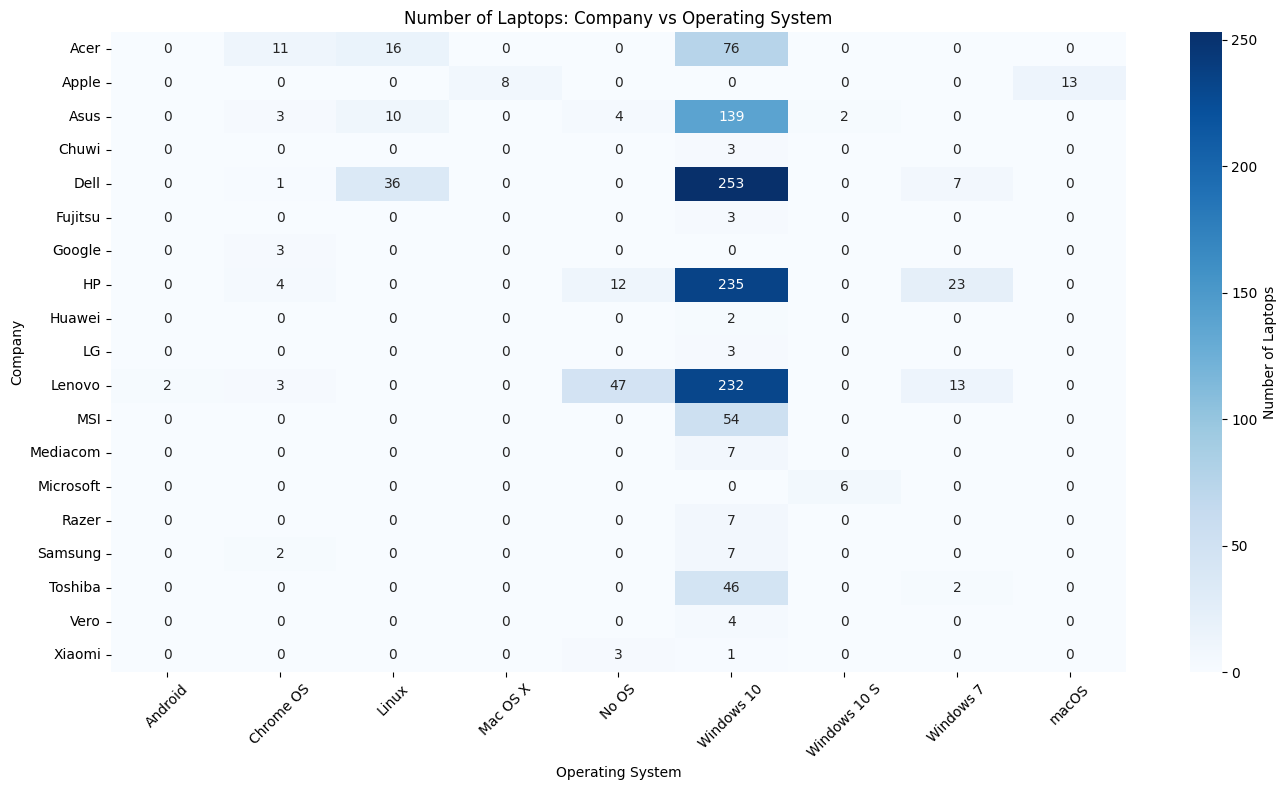

In [ ]:
# 1. Count of Laptops by Company and OS
plt.figure(figsize=(14, 8))
company_os_count = pd.crosstab(df['company'], df['opsys'])
sns.heatmap(company_os_count, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Laptops'})
plt.title('Number of Laptops: Company vs Operating System')
plt.xlabel('Operating System')
plt.ylabel('Company')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

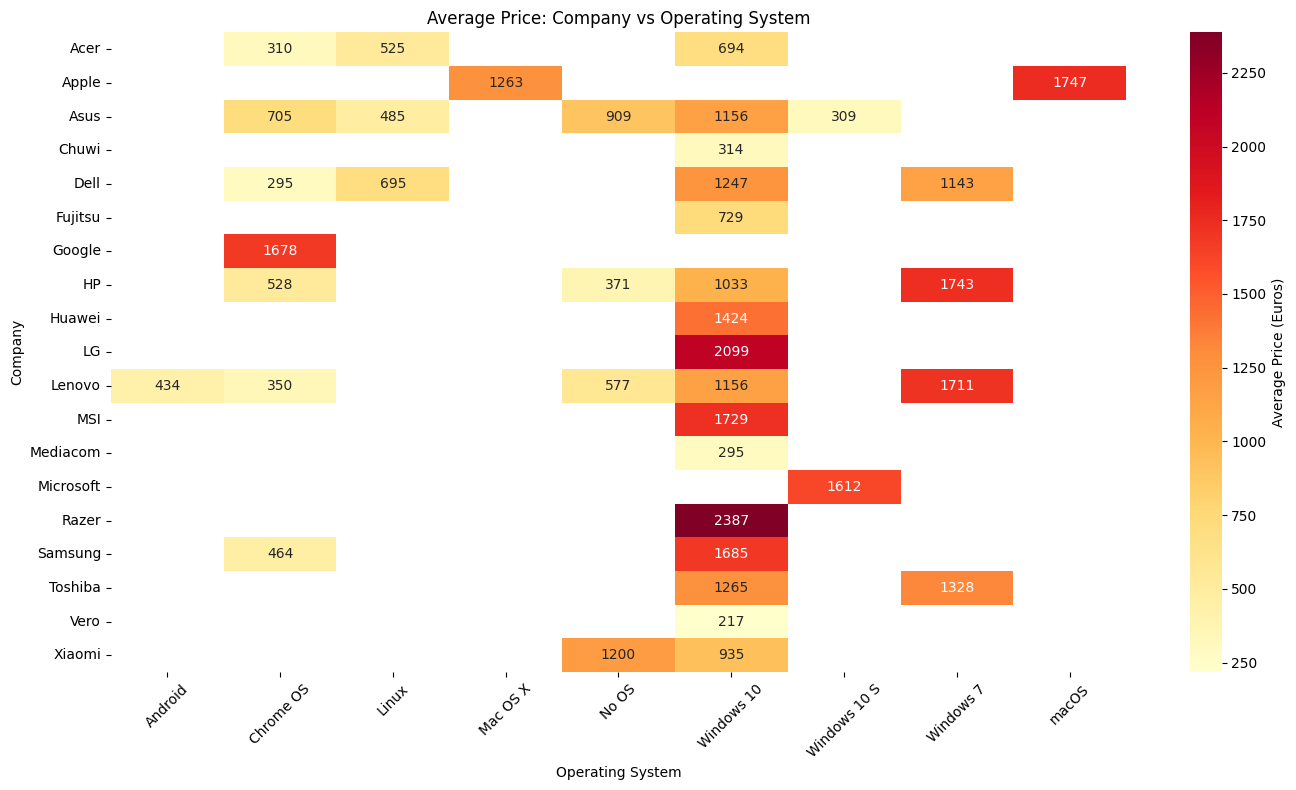

In [ ]:
# 2. Average Price by Company and OS
plt.figure(figsize=(14, 8))
company_os_price = df.groupby(['company', 'opsys'])['price_euros'].mean().unstack()
sns.heatmap(company_os_price, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Average Price (Euros)'})
plt.title('Average Price: Company vs Operating System')
plt.xlabel('Operating System')
plt.ylabel('Company')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key Steps in the Analysis:
Data Loading and Preprocessing

The dataset includes columns like laptop_id, company, product, typename, inches, screenresolution, cpu, ram, memory, gpu, opsys, weight, and price_euros.

Categorical columns were handled (missing values filled with mode or "Unknown").

Numerical features were analyzed for correlation with price_euros.

Correlation Analysis

Only numerical features (inches and laptop_id) showed very weak positive correlations with price_euros (0.042 and 0.071, respectively).

This suggests that numerical features alone are not strong predictors of price.

Categorical Feature Encoding

Label encoding was applied to ordinal features (e.g., ram was encoded, though the output shows it as "Ram" with a capital "R", possibly a typo).

Other categorical features (e.g., company, product, cpu, gpu, etc.) were likely one-hot encoded or label encoded later (not shown in the provided code snippet).

Price Tier Creation

The data was divided into three price tiers (Low, Medium, High) using quantiles.

Most Influential Factors Affecting Laptop Prices:
From the analysis, the following factors are likely the most influential:

RAM

The code explicitly label-encodes ram (though written as "Ram" in the output), indicating it is treated as an ordinal categorical feature. RAM size is a well-known driver of laptop prices.

Company (Brand)

Brands like Apple, Dell, HP, etc., often have significant price premiums due to perceived quality, design, and performance.

CPU (Processor)

The processor type and speed (e.g., Intel Core i7 vs. i5) greatly impact performance and price.

GPU (Graphics Card)

Dedicated GPUs (e.g., NVIDIA GeForce) are more expensive than integrated graphics (e.g., Intel HD Graphics).

Screen Resolution

Higher resolutions (e.g., Retina Display, 4K) increase costs.

Type (e.g., Ultrabook, Notebook)

Ultrabooks (premium lightweight laptops) are typically more expensive than standard notebooks.

Storage (Memory)

SSD storage is more expensive than HDD, and larger capacities command higher prices.

Operating System

macOS systems (Apple) tend to be pricier than Windows or Linux counterparts.

Screen Size (Inches)

Though correlation is weak, larger screens often come with higher prices.

Weight

Lighter laptops (e.g., Ultrabooks) are often more expensive due to premium materials and engineering.

Why Numerical Correlation Was Low:
The dataset contains many categorical features (e.g., company, cpu, gpu) that are more predictive than numerical ones like inches or laptop_id.

These categorical features were likely encoded and used in modeling (e.g., linear regression) later, but the correlation analysis only considered numerical features.

R
Conclusion:
The most influential factors affecting laptop prices are RAM, brand (company), CPU, GPU, screen resolution, type, storage, operating system, screen size, and weight. The weak correlation from numerical features alone highlights the importance of categorical features in determining laptop prices.

In [ ]:
# 1. CPU-Related Features
df['cpu_brand'] = df['cpu'].str.extract(r'(Intel|AMD)')
df['cpu_speed_ghz'] = df['cpu'].str.extract(r'(\d+\.\d+)GHz').astype(float)
df['cpu_generation'] = df['cpu'].str.extract(r'(\d+)th').fillna(df['cpu'].str.extract(r'(\d+)\w+U'))
df['cpu_type'] = df['cpu'].str.extract(r'(i3|i5|i7|i9|Ryzen|Celeron|Pentium|Xeon)')

df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price_euros,Price_Tier,Price_Quartile,cpu_brand,cpu_speed_ghz,cpu_generation,cpu_type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,High,Q3,Intel,2.3,NaN,i5
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,macOS,1.34,898.94,Medium,Q2,Intel,1.8,NaN,i5
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,No OS,1.86,575.00,Low,Q1,Intel,2.5,720,i5
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,macOS,1.83,2537.45,High,Q4,Intel,2.7,NaN,i7
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,High,Q4,Intel,3.1,NaN,i5


In [ ]:
# 2. GPU-Related Features
df['gpu_brand'] = df['gpu'].str.extract(r'(Intel|AMD|NVIDIA)')
df['gpu_type'] = df['gpu'].str.extract(r'(GTX|RTX|Radeon|Iris|HD|UHD|MX)')
df['gpu_is_dedicated'] = df['gpu'].str.contains('GTX|RTX|Radeon|GeForce').astype(int)

df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,price_euros,Price_Tier,Price_Quartile,cpu_brand,cpu_speed_ghz,cpu_generation,cpu_type,gpu_brand,gpu_type,gpu_is_dedicated
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,1339.69,High,Q3,Intel,2.3,NaN,i5,Intel,Iris,0
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,898.94,Medium,Q2,Intel,1.8,NaN,i5,Intel,HD,0
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,575.00,Low,Q1,Intel,2.5,720,i5,Intel,HD,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,2537.45,High,Q4,Intel,2.7,NaN,i7,AMD,Radeon,1
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,1803.60,High,Q4,Intel,3.1,NaN,i5,Intel,Iris,0


In [ ]:
# 3. Screen Resolution Features
df['resolution_width'] = df['screenresolution'].str.extract(r'(\d+)x').astype(float)
df['resolution_height'] = df['screenresolution'].str.extract(r'x(\d+)').astype(float)
df['resolution_pixels'] = df['resolution_width'] * df['resolution_height']
df['screen_type'] = df['screenresolution'].str.extract(r'(IPS|Retina|Touchscreen|Full HD|4K)')
df['is_touchscreen'] = df['screenresolution'].str.contains('Touchscreen').astype(int)

df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,cpu_generation,cpu_type,gpu_brand,gpu_type,gpu_is_dedicated,resolution_width,resolution_height,resolution_pixels,screen_type,is_touchscreen
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,NaN,i5,Intel,Iris,0,2560.0,1600.0,4096000.0,IPS,0
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,NaN,i5,Intel,HD,0,1440.0,900.0,1296000.0,NaN,0
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,720,i5,Intel,HD,0,1920.0,1080.0,2073600.0,Full HD,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,NaN,i7,AMD,Radeon,1,2880.0,1800.0,5184000.0,IPS,0
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,NaN,i5,Intel,Iris,0,2560.0,1600.0,4096000.0,IPS,0


In [ ]:

print(f"Memory column dtype: {df['memory'].dtype}")
print(f"Sample memory values: {df['memory'].head()}")

memory_str = df['memory'].astype(str)  

# 4. Memory Features (using the string representation)
df['has_ssd'] = memory_str.str.contains('SSD').astype(int)
df['has_hdd'] = memory_str.str.contains('HDD').astype(int)
df['has_flash_storage'] = memory_str.str.contains('Flash').astype(int)
df['memory_type'] = memory_str.str.extract(r'(SSD|HDD|Flash|Hybrid)')

df.head()

Memory column dtype: int64
Sample memory values: 0    128
1    128
2    256
3    512
4    256
Name: memory, dtype: int64


,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,gpu_is_dedicated,resolution_width,resolution_height,resolution_pixels,screen_type,is_touchscreen,has_ssd,has_hdd,has_flash_storage,memory_type
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,0,2560.0,1600.0,4096000.0,IPS,0,0,0,0,NaN
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,0,1440.0,900.0,1296000.0,NaN,0,0,0,0,NaN
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,0,1920.0,1080.0,2073600.0,Full HD,0,0,0,0,NaN
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,1,2880.0,1800.0,5184000.0,IPS,0,0,0,0,NaN
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,0,2560.0,1600.0,4096000.0,IPS,0,0,0,0,NaN


In [ ]:
# 5. Operating System Features
df['os_type'] = df['opsys'].str.extract(r'(Windows|macOS|Linux|No OS|Chrome)')
df['is_windows'] = df['opsys'].str.contains('Windows').astype(int)
df['is_macos'] = df['opsys'].str.contains('macOS').astype(int)

df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,resolution_pixels,screen_type,is_touchscreen,has_ssd,has_hdd,has_flash_storage,memory_type,os_type,is_windows,is_macos
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,4096000.0,IPS,0,0,0,0,NaN,macOS,0,1
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,1296000.0,NaN,0,0,0,0,NaN,macOS,0,1
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,2073600.0,Full HD,0,0,0,0,NaN,No OS,0,0
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,5184000.0,IPS,0,0,0,0,NaN,macOS,0,1
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,4096000.0,IPS,0,0,0,0,NaN,macOS,0,1


In [ ]:
# 6. Size and Weight Features

# The weight column is already numeric (float), so no need for string extraction
# Create weight categories using the numeric weight values
df['weight_category'] = pd.cut(df['weight'], 
                              bins=[0, 1.5, 2, 2.5, 3, 4, 10],  # Added upper bound
                              labels=['Ultra-light', 'Light', 'Medium', 'Heavy', 'Very Heavy', 'Extreme'],
                              include_lowest=True)

# Create screen size categories
df['screen_size_category'] = pd.cut(df['inches'],
                                   bins=[0, 13, 15, 17, 20],
                                   labels=['Small', 'Medium', 'Large', 'Extra Large'],
                                   include_lowest=True)

# Create screen size to weight ratio (inches per kg)
df['screen_size_weight_ratio'] = df['inches'] / df['weight']

print("Weight and screen size features created successfully!")
print(f"Weight range: {df['weight'].min():.2f}kg to {df['weight'].max():.2f}kg")
print(f"Screen size range: {df['inches'].min():.1f}\" to {df['inches'].max():.1f}\"")

df.head()

Weight and screen size features created successfully!
Weight range: 0.69kg to 3.50kg
Screen size range: 11.6" to 18.0"


,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,has_ssd,has_hdd,has_flash_storage,memory_type,os_type,is_windows,is_macos,weight_category,screen_size_category,screen_size_weight_ratio
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,0,0,0,NaN,macOS,0,1,Ultra-light,Medium,9.708029
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,0,0,0,NaN,macOS,0,1,Ultra-light,Medium,9.925373
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,0,0,0,NaN,No OS,0,0,Light,Large,8.387097
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,0,0,0,NaN,macOS,0,1,Light,Large,8.415301
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,0,0,0,NaN,macOS,0,1,Ultra-light,Medium,9.708029


In [ ]:
# 7. Brand and Product Features
df['is_premium_brand'] = df['company'].isin(['Apple', 'Dell', 'HP', 'Lenovo']).astype(int)
df['product_line'] = df['product'].str.extract(r'(\w+)').fillna('Unknown')

df.head()

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,has_flash_storage,memory_type,os_type,is_windows,is_macos,weight_category,screen_size_category,screen_size_weight_ratio,is_premium_brand,product_line
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,0,NaN,macOS,0,1,Ultra-light,Medium,9.708029,1,MacBook
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,0,NaN,macOS,0,1,Ultra-light,Medium,9.925373,1,Macbook
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,0,NaN,No OS,0,0,Light,Large,8.387097,1,250
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,0,NaN,macOS,0,1,Light,Large,8.415301,1,MacBook
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,0,NaN,macOS,0,1,Ultra-light,Medium,9.708029,1,MacBook


In [ ]:
# 9. Performance Score Features

# First, ensure all columns are numeric
df['cpu_speed_ghz'] = pd.to_numeric(df['cpu_speed_ghz'], errors='coerce')
df['ram'] = pd.to_numeric(df['ram'], errors='coerce')
df['cpu_generation'] = pd.to_numeric(df['cpu_generation'], errors='coerce')

# Fill NaN values with appropriate defaults
df['cpu_speed_ghz'] = df['cpu_speed_ghz'].fillna(df['cpu_speed_ghz'].median())
df['ram'] = df['ram'].fillna(df['ram'].median())
df['cpu_generation'] = df['cpu_generation'].fillna(1)  # Default to 1 if generation is missing

# Now create the performance score
df['cpu_performance_score'] = df['cpu_speed_ghz'] * df['ram'] * df['cpu_generation']


print("Performance score created successfully!")
print(df[['cpu_speed_ghz', 'ram', 'cpu_generation', 'cpu_performance_score']].head())

Performance score created successfully!
   cpu_speed_ghz  ram  cpu_generation  cpu_performance_score
0            2.3    8             1.0                   18.4
1            1.8    8             1.0                   14.4
2            2.5    8           720.0                14400.0
3            2.7   14             1.0                   37.8
4            3.1    8             1.0                   24.8


In [ ]:
# 10. Interaction Features

# First, check what's in these columns
print("RAM column sample:", df['ram'].head().tolist())
print("Memory column sample:", df['memory'].head().tolist())
print("Data types:")
print(f"RAM dtype: {df['ram'].dtype}")
print(f"Memory dtype: {df['memory'].dtype}")

# Clean and convert both columns to numeric values
def clean_storage_value(value):
    """
    Convert storage values like '512GB', '1TB', etc. to numeric GB values
    """
    if pd.isna(value):
        return np.nan
    
    # If already numeric, return as is
    if isinstance(value, (int, float)):
        return value
    
    # Convert to string and clean
    value_str = str(value).upper().strip()
    
    # Remove non-alphanumeric characters (keep numbers and TB/GB)
    value_str = ''.join(c for c in value_str if c.isalnum() or c in ['.', ' '])
    
    # Handle TB conversion (1TB = 1024GB)
    if 'TB' in value_str:
        num = value_str.replace('TB', '').strip()
        try:
            return float(num) * 1024
        except:
            return np.nan
    
    # Handle GB conversion
    elif 'GB' in value_str:
        num = value_str.replace('GB', '').strip()
        try:
            return float(num)
        except:
            return np.nan
    
    # If no units specified, assume GB
    else:
        try:
            return float(value_str)
        except:
            return np.nan

# Apply cleaning to both columns
df['ram_gb'] = df['ram'].apply(clean_storage_value)
df['memory_gb'] = df['memory'].apply(clean_storage_value)

# Fill missing values with median
df['ram_gb'] = df['ram_gb'].fillna(df['ram_gb'].median())
df['memory_gb'] = df['memory_gb'].fillna(df['memory_gb'].median())

# Now create the interaction feature
df['ram_memory_interaction'] = df['ram_gb'] * df['memory_gb']

print("Interaction feature created successfully!")
print(df[['ram', 'memory', 'ram_gb', 'memory_gb', 'ram_memory_interaction']].head())

RAM column sample: [8, 8, 8, 14, 8]
Memory column sample: [128, 128, 256, 512, 256]
Data types:
RAM dtype: int64
Memory dtype: int64
Interaction feature created successfully!
   ram  memory  ram_gb  memory_gb  ram_memory_interaction
0    8     128       8        128                    1024
1    8     128       8        128                    1024
2    8     256       8        256                    2048
3   14     512      14        512                    7168
4    8     256       8        256                    2048


In [ ]:
# Fill missing values for the new features
df['cpu_brand'].fillna('Unknown', inplace=True)
df['cpu_type'].fillna('Unknown', inplace=True)
df['gpu_brand'].fillna('Unknown', inplace=True)
df['gpu_type'].fillna('Unknown', inplace=True)
df['screen_type'].fillna('Standard', inplace=True)
df['memory_type'].fillna('Unknown', inplace=True)
df['os_type'].fillna('Unknown', inplace=True)
df['cpu_generation'].fillna(0, inplace=True)
df['cpu_speed_ghz'].fillna(df['cpu_speed_ghz'].median(), inplace=True)
df['resolution_width'].fillna(df['resolution_width'].median(), inplace=True)
df['resolution_height'].fillna(df['resolution_height'].median(), inplace=True)
df['resolution_pixels'].fillna(df['resolution_pixels'].median(), inplace=True)

df.head()

C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\3589610557.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cpu_brand'].fillna('Unknown', inplace=True)
C:\Users\Abas\AppData\Local\Temp\ipykernel_7816\3589610557.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,is_macos,weight_category,screen_size_category,screen_size_weight_ratio,is_premium_brand,product_line,cpu_performance_score,ram_gb,memory_gb,ram_memory_interaction
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,1,Ultra-light,Medium,9.708029,1,MacBook,18.4,8,128,1024
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,1,Ultra-light,Medium,9.925373,1,Macbook,14.4,8,128,1024
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,0,Light,Large,8.387097,1,250,14400.0,8,256,2048
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,1,Light,Large,8.415301,1,MacBook,37.8,14,512,7168
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,1,Ultra-light,Medium,9.708029,1,MacBook,24.8,8,256,2048


In [ ]:
# Convert categorical features to numerical using Label Encoding
from sklearn.preprocessing import LabelEncoder

categorical_features = ['cpu_brand', 'cpu_type', 'gpu_brand', 'gpu_type', 
                       'screen_type', 'memory_type', 'os_type', 
                       'screen_size_category', 'weight_category', 'product_line']

label_encoders = {}
for feature in categorical_features:
    if feature in df.columns:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature].astype(str))
        label_encoders[feature] = le

print("New features created successfully!")
print(f"Total features after engineering: {len(df.columns)}")
print("New columns:", [col for col in df.columns if col not in ['laptop_id', 'company', 'product', 'typename', 
                                                              'screenresolution', 'cpu', 'ram', 'memory', 
                                                              'gpu', 'opsys', 'weight', 'price_euros']])

df.head()

New features created successfully!
Total features after engineering: 43
New columns: ['inches', 'Price_Tier', 'Price_Quartile', 'cpu_brand', 'cpu_speed_ghz', 'cpu_generation', 'cpu_type', 'gpu_brand', 'gpu_type', 'gpu_is_dedicated', 'resolution_width', 'resolution_height', 'resolution_pixels', 'screen_type', 'is_touchscreen', 'has_ssd', 'has_hdd', 'has_flash_storage', 'memory_type', 'os_type', 'is_windows', 'is_macos', 'weight_category', 'screen_size_category', 'screen_size_weight_ratio', 'is_premium_brand', 'product_line', 'cpu_performance_score', 'ram_gb', 'memory_gb', 'ram_memory_interaction']


,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,...,is_macos,weight_category,screen_size_category,screen_size_weight_ratio,is_premium_brand,product_line,cpu_performance_score,ram_gb,memory_gb,ram_memory_interaction
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128,Intel Iris Plus Graphics 640,...,1,3,2,9.708029,1,86,18.4,8,128,1024
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128,Intel HD Graphics 6000,...,1,3,2,9.925373,1,87,14.4,8,128,1024
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256,Intel HD Graphics 620,...,0,1,1,8.387097,1,4,14400.0,8,256,2048
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,14,512,AMD Radeon Pro 455,...,1,1,1,8.415301,1,86,37.8,14,512,7168
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256,Intel Iris Plus Graphics 650,...,1,3,2,9.708029,1,86,24.8,8,256,2048


In [ ]:
# First, ensure you have the complete preprocessing and model training code
# Prepare features and target
X = df.drop('price_euros', axis=1)
y = df['price_euros']

# Convert all categorical columns to string type
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].astype(str)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Split the data FIRST before any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Create and train the linear regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

# Train the model on the training data
model.fit(X_train, y_train)

# Now make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" MODEL EVALUATION METRICS ")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} €")
print(f"Mean Absolute Error (MAE): {mae:.2f} €")
print(f"R-squared (R2): {r2:.4f}")
print(f"Explained Variance: {r2*100:.2f}%")



 MODEL EVALUATION METRICS 
Root Mean Squared Error (RMSE): 284.03 €
Mean Absolute Error (MAE): 189.35 €
R-squared (R2): 0.8103
Explained Variance: 81.03%


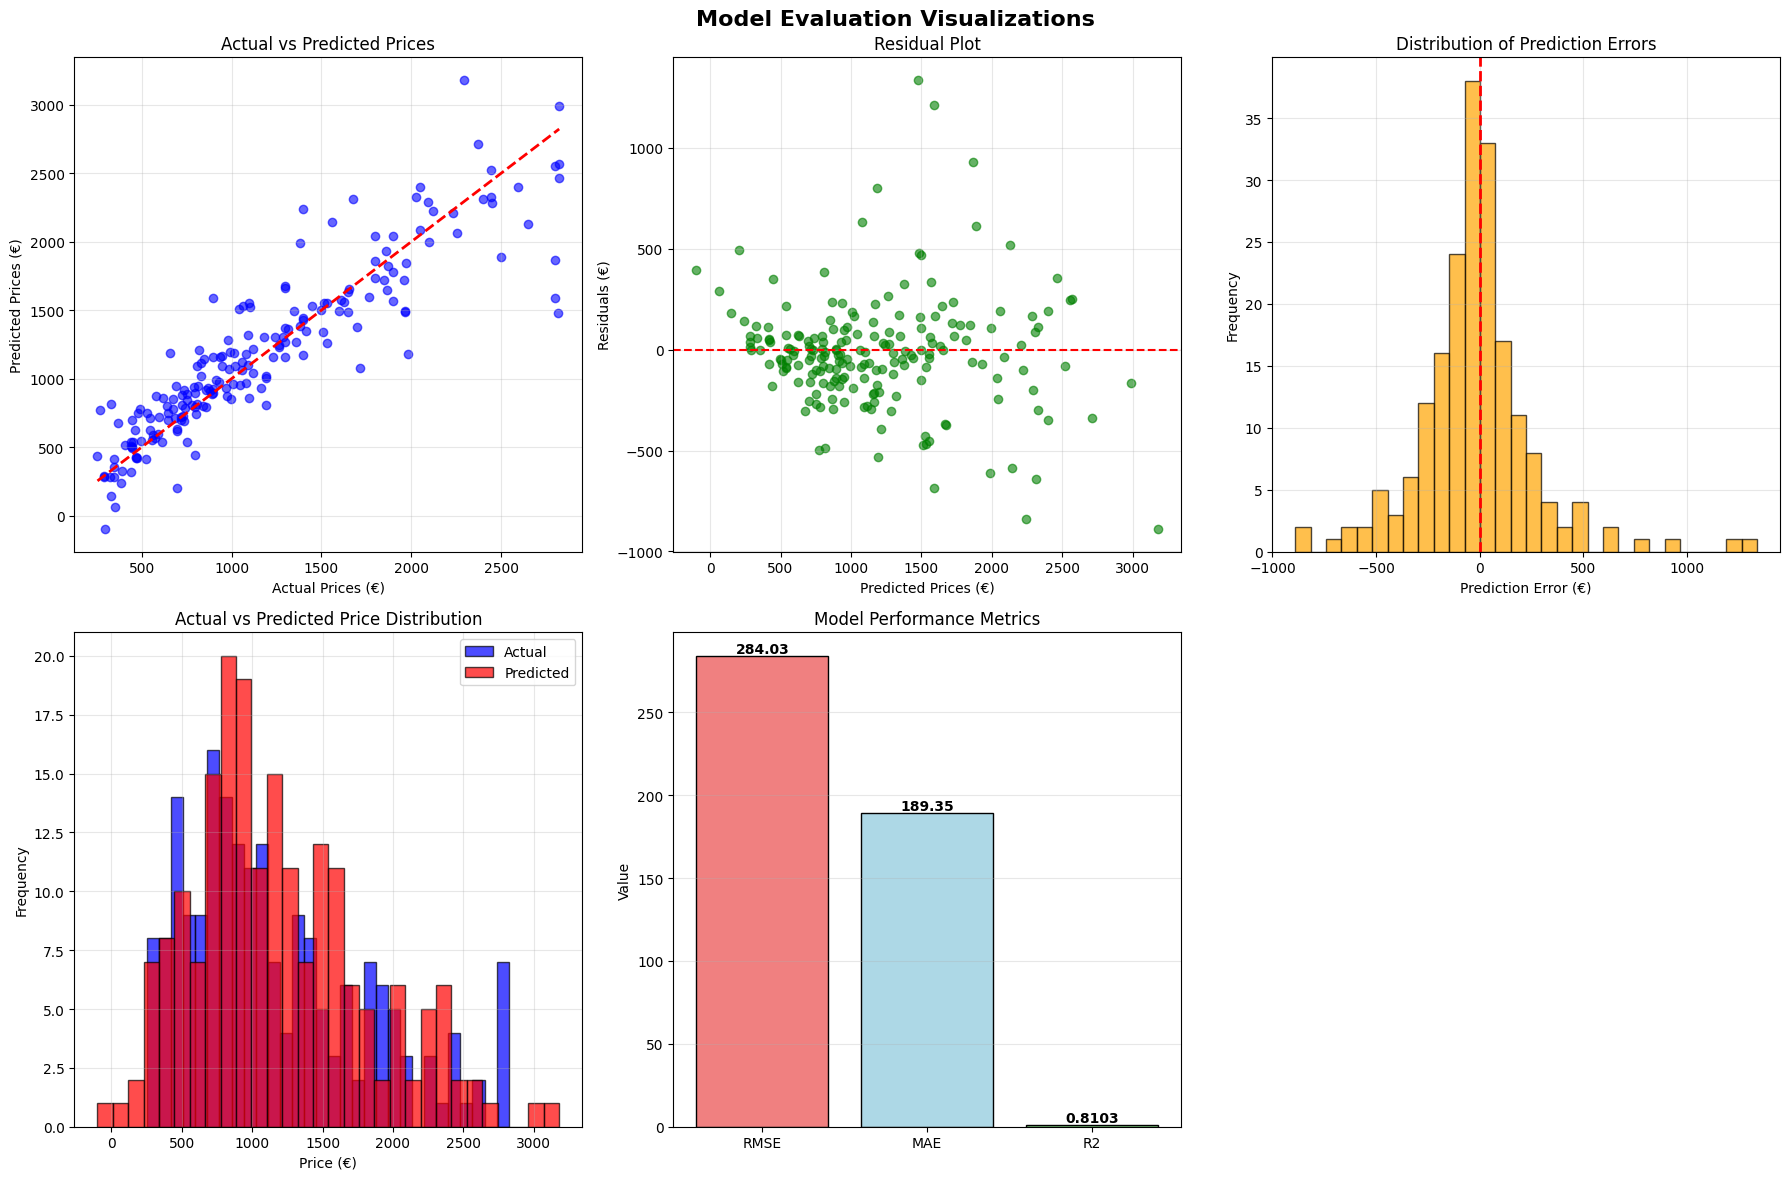

In [ ]:
# Create subplots for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Evaluation Visualizations', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Scatter Plot
axes[0,0].scatter(y_test, y_pred, alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Prices (€)')
axes[0,0].set_ylabel('Predicted Prices (€)')
axes[0,0].set_title('Actual vs Predicted Prices')
axes[0,0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_test - y_pred
axes[0,1].scatter(y_pred, residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('Predicted Prices (€)')
axes[0,1].set_ylabel('Residuals (€)')
axes[0,1].set_title('Residual Plot')
axes[0,1].grid(True, alpha=0.3)

# 3. Error Distribution Histogram
axes[0,2].hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0,2].set_xlabel('Prediction Error (€)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Distribution of Prediction Errors')
axes[0,2].grid(True, alpha=0.3)

# 4. Price Distribution Comparison
axes[1,0].hist(y_test, bins=30, alpha=0.7, label='Actual', color='blue', edgecolor='black')
axes[1,0].hist(y_pred, bins=30, alpha=0.7, label='Predicted', color='red', edgecolor='black')
axes[1,0].set_xlabel('Price (€)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Actual vs Predicted Price Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Metrics Comparison
metrics = ['RMSE', 'MAE', 'R2']
values = [rmse, mae, r2]
colors = ['lightcoral', 'lightblue', 'lightgreen']

bars = axes[1,1].bar(metrics, values, color=colors, edgecolor='black')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Model Performance Metrics')
axes[1,1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.2f}' if metrics[bars.index(bar)] != 'R2' else f'{value:.4f}',
                 ha='center', va='bottom', fontweight='bold')

# Remove empty subplot
fig.delaxes(axes[1,2])

plt.tight_layout()
plt.show()



In [ ]:
# Additional detailed analysis
print("\n=== ADDITIONAL ANALYSIS ===")
print(f"Average Prediction Error: {residuals.mean():.2f} €")
print(f"Standard Deviation of Errors: {residuals.std():.2f} €")
print(f"Maximum Overestimation: {residuals.min():.2f} €")
print(f"Maximum Underestimation: {residuals.max():.2f} €")

# Calculate percentage errors
percentage_errors = (abs(residuals) / y_test) * 100
print(f"Mean Absolute Percentage Error: {percentage_errors.mean():.2f}%")
print(f"Median Absolute Percentage Error: {np.median(percentage_errors):.2f}%")


=== ADDITIONAL ANALYSIS ===
Average Prediction Error: -17.18 €
Standard Deviation of Errors: 284.24 €
Maximum Overestimation: -890.12 €
Maximum Underestimation: 1337.02 €
Mean Absolute Percentage Error: 19.68%
Median Absolute Percentage Error: 11.44%


In [15]:
import joblib

if 'model' in globals():
	# Save the trained model pipeline
	joblib.dump(model, 'laptop_price_model.joblib')

	# Save the feature columns used for prediction
	joblib.dump((X_train.columns), 'model_features.joblib')

	print("Model and feature columns saved successfully!")
else:
	print("The variable 'model' is not defined. Please run the cell where the model is trained before saving.")

The variable 'model' is not defined. Please run the cell where the model is trained before saving.
